In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Training Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")
train_df.head()

Training Data Shape: (1460, 81)
Test Data Shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


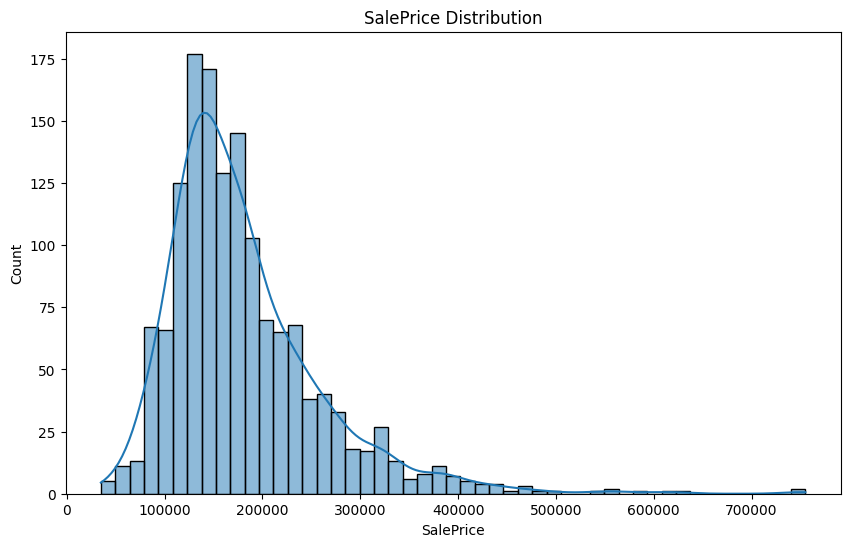

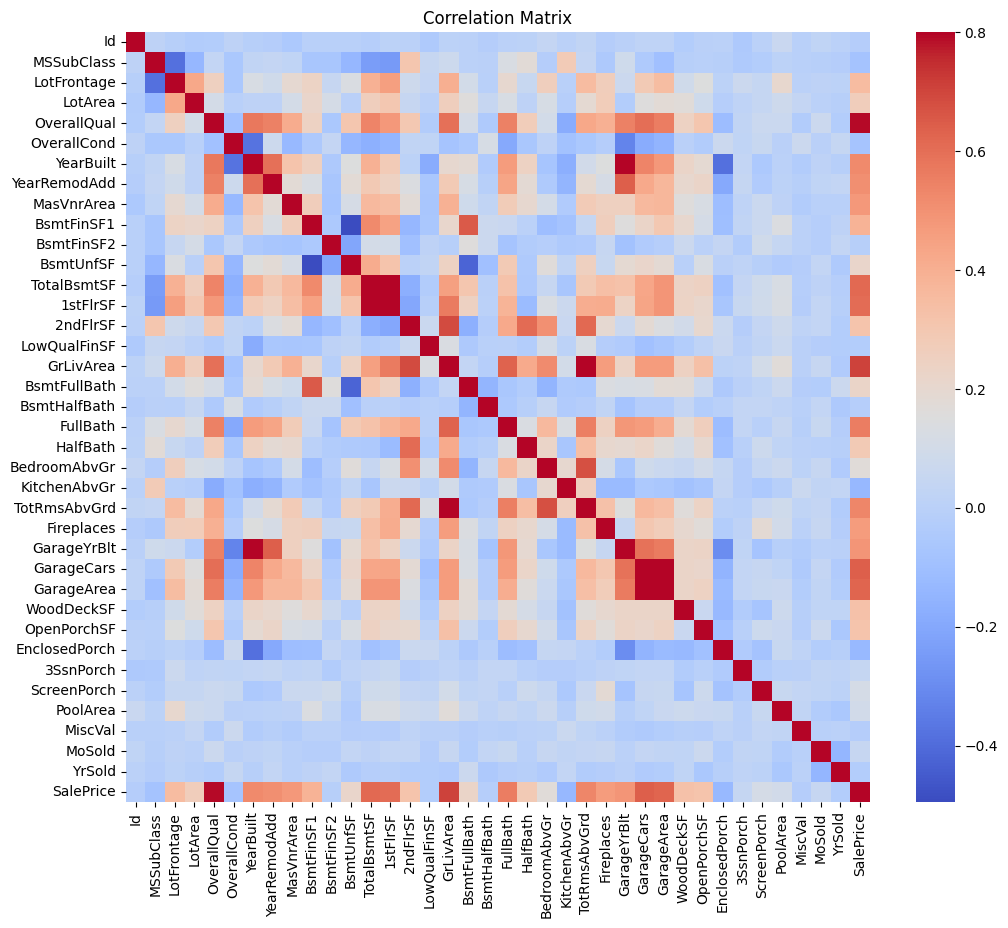

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


In [2]:
# 1. Target Variable Analysis
plt.figure(figsize=(10,6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('SalePrice Distribution')
plt.show()

# 2. Correlation Map
plt.figure(figsize=(12, 10))
numeric_df = train_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=0.8)
plt.title('Correlation Matrix')
plt.show()

# Top correlated features
print(corr_matrix['SalePrice'].sort_values(ascending=False).head(10))

In [28]:
# Combine train and test for consistent preprocessing
y = np.log1p(train_df['SalePrice']) # Log transform target
train_features = train_df.drop(['SalePrice', 'Id'], axis=1)
test_features = test_df.drop(['Id'], axis=1)

# Concatenate for preprocessing
all_data = pd.concat([train_features, test_features]).reset_index(drop=True)

# 1. Handle Missing Values according to data_description.txt
# For these columns, NA means "None" (e.g., no pool, no fence)
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for col in none_cols:
    all_data[col] = all_data[col].fillna('None')

# For LotFrontage, fill with median of neighborhood (homes in same area have similar lot frontage)
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Fill remaining categorical with Mode and numerical with 0 or Median
for col in all_data.columns:
    if all_data[col].dtype == "object":
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    else:
        all_data[col] = all_data[col].fillna(0)

# 2. Feature Engineering
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# 3. Encoding (One-Hot Encoding for categorical variables)
all_data = pd.get_dummies(all_data)

# Split back into train and test
X = all_data.iloc[:len(y), :]
X_test = all_data.iloc[len(y):, :]

print(f"Processed features shape: {X.shape}")

Processed features shape: (1460, 302)


In [29]:
# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Model
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42, eval_metric='rmse')

# Train Model
model.fit(X_train, y_train, verbose=False)

# Make predictions on validation set
preds_val = model.predict(X_val)

# Evaluate (RMSE)
rmse = np.sqrt(mean_squared_error(y_val, preds_val))
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 0.1434


<Figure size 1000x800 with 0 Axes>

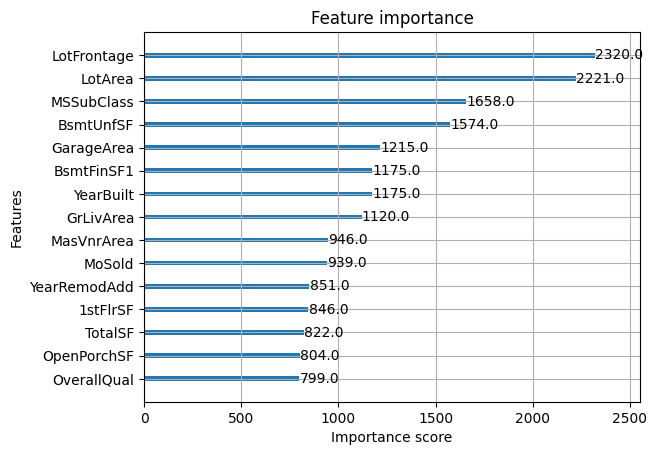

In [30]:
# Plot Feature Importance
from xgboost import plot_importance
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=15)
plt.show()

In [31]:
# Predict on Test Data
final_preds_log = model.predict(X_test)
final_preds = np.expm1(final_preds_log) # Reverse log transformation

# Create Submission DataFrame
submission = pd.DataFrame()
submission['Id'] = test_df['Id']
submission['SalePrice'] = final_preds

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file saved successfully!")

Submission file saved successfully!


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train_df = pd.read_csv('train.csv')
X = train_df.drop(['SalePrice', 'Id'], axis=1)
y = train_df['SalePrice']

# Split Data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Preprocessing
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define Models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and Evaluate
results = []
for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})

results_df = pd.DataFrame(results)
print(results_df)

c:\Users\samwe\Desktop\samwelodiek\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.156e+11, tolerance: 6.967e+08
  model = cd_fast.sparse_enet_coordinate_descent(


               Model          RMSE        R2
0  Linear Regression  65387.569096  0.442588
1              Ridge  29735.413853  0.884725
2              Lasso  30390.517258  0.879590
3      Random Forest  29171.427474  0.889057
4  Gradient Boosting  27508.653152  0.901344
